In [1]:
import pandas as pd #Daten
from matplotlib import pyplot as plt # plots
#import matplotlib as mpl
from matplotlib.ticker import FuncFormatter   # Numberformat plot ticks
# import matplotlib.ticker as ticker
import matplotlib.dates as mdates
# from matplotlib.dates import DateFormatter
import numpy as np

# performance
import datetime
from datetime import datetime, timedelta
from datetime import date # todays date

#import seaborn as sns

import os
now = datetime.now()

## Variablen

In [2]:
# Linien Stärke
lws = 3
lwb = 7
# Bezugsschriftgröße
size = 25


# output größe der bilder
h = 16*1.4
v = 9
dpi = 200

# heutiges datum
today = date.today().strftime("%d.%m.%Y")

# Datum einstellen 
minticks = 14
maxticks = 14

In [3]:
Laufwerk = "D:\\"
name_output_df = 'Dataframes\\data_WHO_data.csv'

pfad_output = "Github\\Auswertung_Covid_19\\output\\"
pfad_onedrive = "OneDrive\\Auswertung_Covid_19\\"
pfad_input = "Github\\Auswertung_Covid_19\\input\\"
name_performance = 'Dataframes\\df_performance.csv'

name_6_1 = "plot_6-1_Änderungsrate MW cases"
name_6_2 = "plot_6-2_VOC"

In [4]:
# Webabruf - CSV einlesen
data = pd.read_csv("https://covid19.who.int/WHO-COVID-19-global-data.csv")

data['Date_reported'] = pd.to_datetime(data.Date_reported, utc=True)

## preprocessing

In [5]:
# Preprocessing

# Filter: Country
df = data[data.Country == 'Germany']

# Referenzdatum
ts = pd.to_datetime('2021-01-15', utc=True)   # YYYY-MM-DD

# Spalten entfernen
df = df.drop(columns=['Country_code', 'WHO_region', 'Country', 
                      'Cumulative_cases', 'New_deaths', 
                      'New_deaths', 'Cumulative_deaths'])

#Datum Filter
df = df.loc[df.Date_reported >= ts, :]

# df["Country"].unique()

In [6]:
df.head(3)

,Date_reported,New_cases
33372,2021-01-15 00:00:00+00:00,22368
33373,2021-01-16 00:00:00+00:00,18678
33374,2021-01-17 00:00:00+00:00,13882


## Berechnungen

In [7]:
# Mittelwert
df["MA"] = df["New_cases"].rolling(window=7, min_periods=1).mean()
df.head(1)

,Date_reported,New_cases,MA
33372,2021-01-15 00:00:00+00:00,22368,22368.0


In [8]:
df.head(1)

,Date_reported,New_cases,MA
33372,2021-01-15 00:00:00+00:00,22368,22368.0


In [9]:

df["change_1"] = 100 * df["MA"].pct_change(periods=1)   # Berechnung OK - 20.02.2021 PW

df["change_1_MW"] = df["change_1"].rolling(window=3, min_periods=1, center=True).mean()  # OK 20.02.2021 PW

df["MSTD"] = df["change_1"].rolling(window=7,min_periods=1).std()

df["change_1_MW_std+"] = df["change_1_MW"] + df["MSTD"]
df["change_1_MW_std-"] = df["change_1_MW"] - df["MSTD"]

# ger_change["change_1_MW_std+"] = ger_change["change_1_MW"] + 
# ger_change["change_1_MW_std-"] = 

df["week_isocalendar"] = df["Date_reported"].dt.isocalendar().week 

df["R1"] = 0

#df

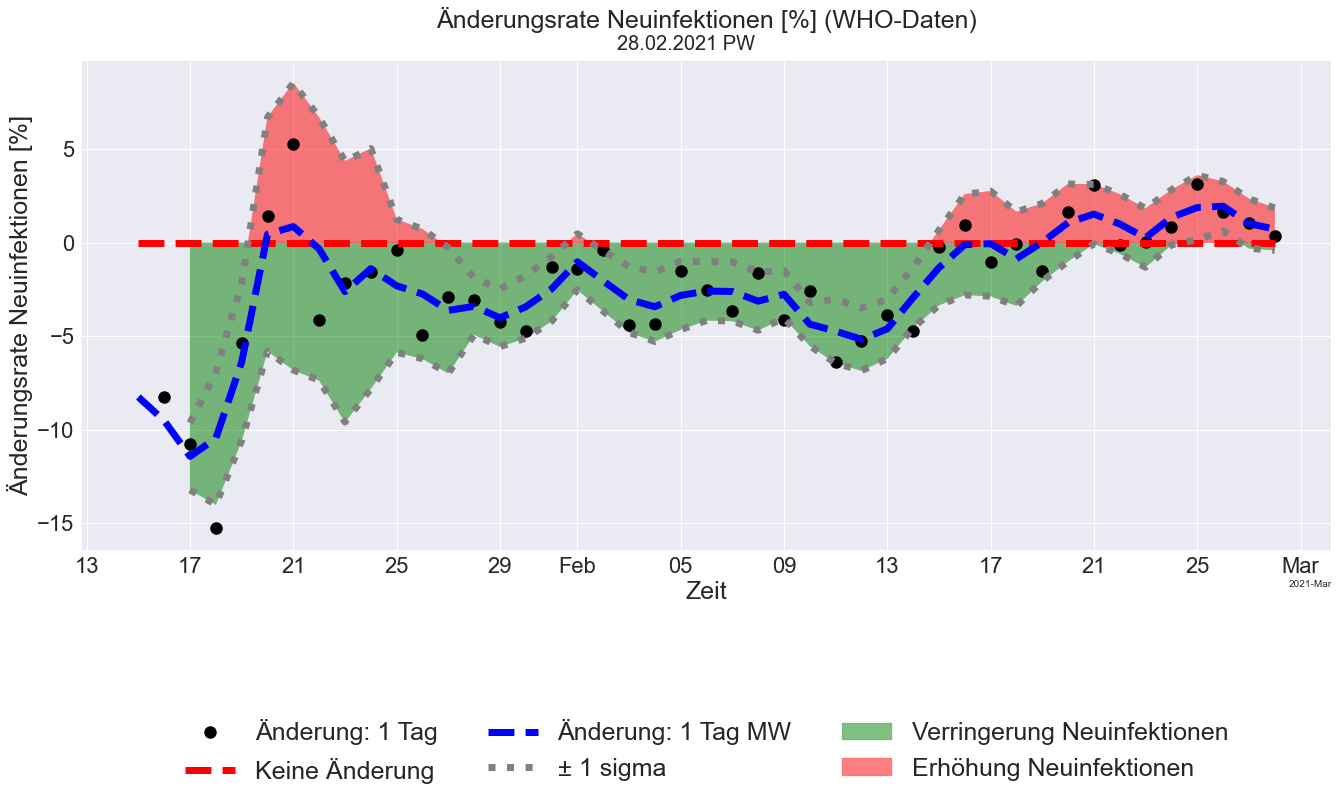

In [10]:

plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(h, v))

# # Neue Fälle pro Tag pro 100.000 Einwohner - 02.12.2020 

# Datenpunkte
ax1 = plt.plot(df.Date_reported,df['change_1'], color="black", linestyle = '',
               marker='.', markersize = size,
               label = "Änderung: 1 Tag")

# Grenzlinie
ax5 = plt.plot(df.Date_reported,df['R1'], color="red", linestyle = 'dashed', linewidth = lwb, 
               label = "Keine Änderung")

# Mittelwert
ax6 = plt.plot(df.Date_reported,df['change_1_MW'], color="blue", linestyle = '--', linewidth = lwb, 
               label = "Änderung: 1 Tag MW")

# sigma
ax6 = plt.plot(df.Date_reported,df['change_1_MW_std+'], color="grey", linestyle = 'dotted', linewidth = lwb, 
               label = "± 1 sigma")

ax6 = plt.plot(df.Date_reported,df['change_1_MW_std-'], color="grey", linestyle = 'dotted', linewidth = lwb, 
               label = "")


plt.fill_between(df.Date_reported, df['change_1_MW_std+'], df['change_1_MW_std-'] , 
                 color='grey',alpha=0, interpolate=True)


# # fill area between lines
plt.fill_between(df.Date_reported, df['change_1_MW_std-'], df['R1'], label = "Verringerung Neuinfektionen", 
                 color='green',alpha=0.5, interpolate=True, where = df['change_1_MW_std-'] < 0 )

plt.fill_between(df.Date_reported, df['change_1_MW_std+'], df['R1'], label = "Erhöhung Neuinfektionen", 
                 color='red',alpha=0.5, interpolate=True, where = df['change_1_MW_std+'] > 0 )



plt.legend(loc='upper center', 
           bbox_to_anchor=(0.5, -0.3),
           fancybox=True, 
           shadow=True, 
           ncol=3, 
           fontsize=size)

# Schriftgrößen x und y achsenwerte
plt.xticks(fontsize=size - 3, rotation = 0)
plt.yticks(fontsize=size -3)

plt.ylabel('Änderungsrate Neuinfektionen [%]', fontsize=size)
plt.xlabel('Zeit', fontsize=size)

plt.title('Änderungsrate Neuinfektionen [%] (WHO-Daten)\n', fontsize=size)
plt.suptitle(today + ' PW', fontsize=size-5, y=0.92)

# ax.set_ylim(ymin=-30)
# ax.set_ylim(ymax=30)

locator = mdates.AutoDateLocator(minticks=minticks, maxticks=maxticks)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)


# Diagramm als Bild exporieren und Auflösung definieren
plt.savefig(Laufwerk + pfad_output +  name_6_1, dpi = dpi, bbox_inches='tight')
plt.savefig(Laufwerk + pfad_onedrive +  name_6_1, dpi = dpi, bbox_inches='tight')




plt.show()
# plt.close()

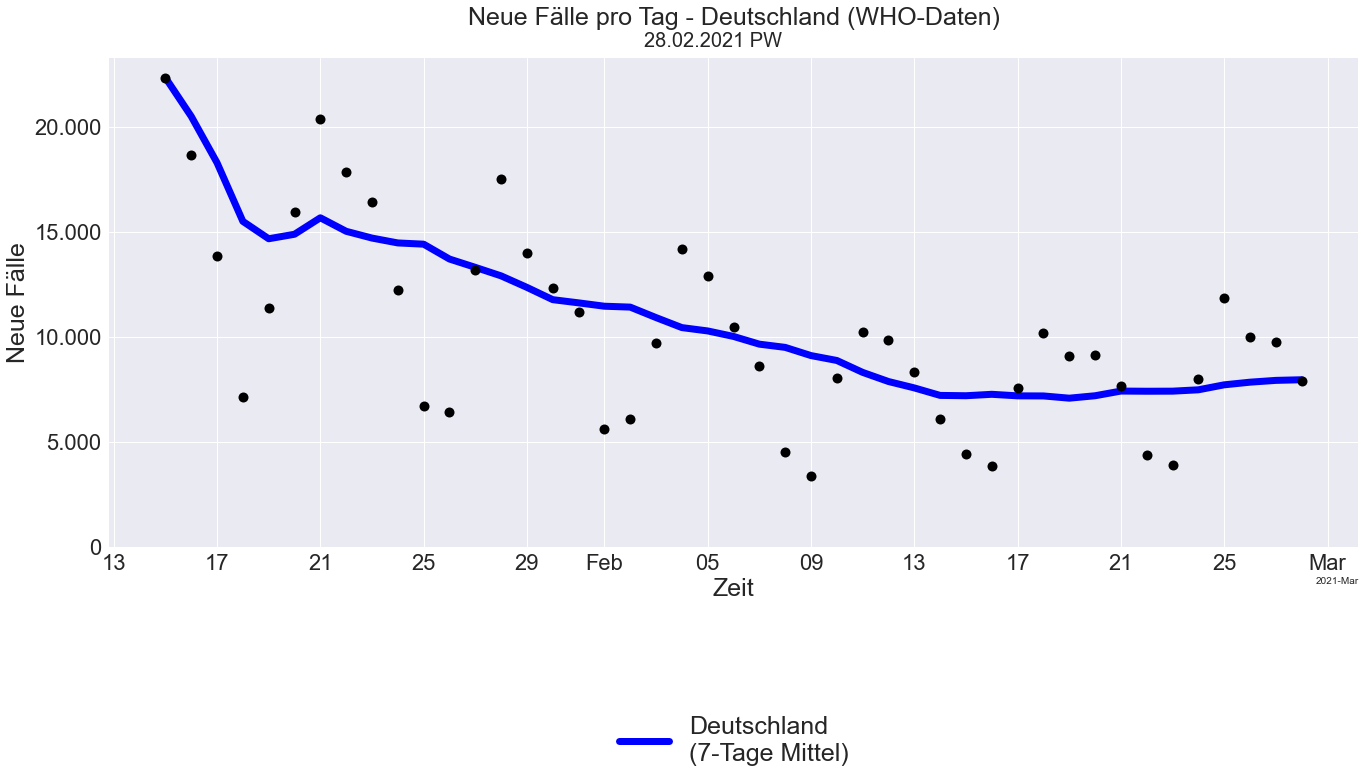

In [11]:
# Größe im 16:9 format und mit Umrechnungsfaktor 1.2 (durch Test ermittelt) für PowerPoint angepasst
# plt.figure(figsize=(h*1.4,v))

def y_axis_thousands(x, pos):
   # 'The two args are the value and tick position'
    return '{:0,d}'.format(int(x)).replace(",",".")
formatter = FuncFormatter(y_axis_thousands)

fig, ax = plt.subplots(figsize=(h, v))

ax.yaxis.set_major_formatter(formatter)


# Neue Fälle pro Tag pro 100.000 Einwohner - 02.12.2020 
ax1 = plt.plot(df.Date_reported,df['MA'], color="blue", linestyle = 'solid', linewidth = lwb, 
               label = "Deutschland\n(7-Tage Mittel)")
ax2 = plt.plot(df.Date_reported,df['New_cases'], marker='.', linestyle='', color="black", markersize = 20)


plt.legend(loc='upper center', 
           bbox_to_anchor=(0.5, -0.3),
           fancybox=True, 
           shadow=True, 
           ncol=3, 
           fontsize=size)

# Schriftgrößen x und y achsenwerte
plt.xticks(fontsize=size - 3, rotation = 0)
plt.yticks(fontsize=size -3)

plt.ylabel('Neue Fälle', fontsize=size)
plt.xlabel('Zeit', fontsize=size)

plt.title('Neue Fälle pro Tag - Deutschland (WHO-Daten)\n', fontsize=size)
plt.suptitle(today + ' PW', fontsize=size-5, y=0.92)

# fill area between lines
# plt.fill_between(df.Date_reported, ger['OTG_cases'], ger['UTG_cases'] , color='red',alpha=0.5)

ax.set_ylim(ymin=0)

locator = mdates.AutoDateLocator(minticks=minticks, maxticks=maxticks)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)


# Diagramm als Bild exporieren und Auflösung definieren
# plt.savefig(Laufwerk + pfad_output +  name_4_1, dpi = dpi, bbox_inches='tight')
# plt.savefig(Laufwerk + pfad_onedrive +  name_4_1, dpi = dpi, bbox_inches='tight')

plt.show()
# plt.close()